In [2]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../fuzzy-tools') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
==============================spm-mcmc-estw
../save/exp=rf_eval~train_config=r~mode=all/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method=spm-mcmc-estw
['0@id=1000'](1#)
Confusion matrix. Using 102 astrophysical features [all] ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


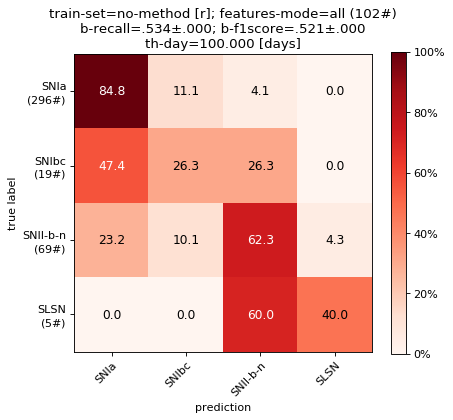

../save/exp=rf_eval~train_config=s~mode=all/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method=spm-mcmc-estw
['0@id=1000'](1#)
Confusion matrix. Using 102 astrophysical features [all] ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


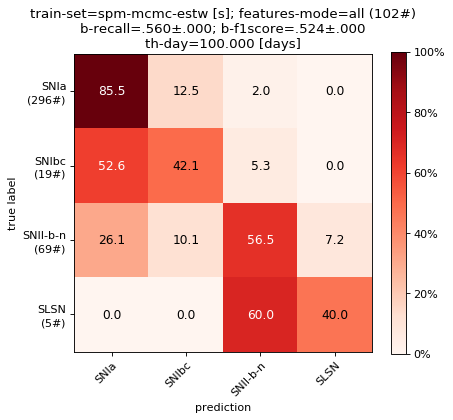

../save/exp=rf_eval~train_config=r+s~mode=all/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method=spm-mcmc-estw


KeyError: 'test'

In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import fuzzytools.files as ftfiles
from fuzzytools.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from fuzzytools.datascience.xerror import XError
from IPython.display import display

def get_kf_text(set_name, kf):
    if kf=='.':
        return f'($\\mu\\pm\\sigma$ from 5-fold cross-validation in {set_name}-set)'
    else:
        return f'($\\mu\\pm\\sigma$ from {kf} k-fold in {set_name}-set)'

def get_mode_text(mode, features):
    if mode=='sne':
        return f'Using {len(features)} SNe selected astrophysical features [{mode}]'
    else:
        return f'Using {len(features)} astrophysical features [{mode}]'
    
mode = 'all' # all spm sne
methods = [
    #'linear-fstw',
    #'bspline-fstw',
    #'spm-mle-fstw',
    #'spm-mle-estw',
    #'spm-mcmc-fstw',
    'spm-mcmc-estw',
]
RANDOM_STATE = 0
lcset_name = 'test'
kf = '.'
thday = 100

for method in methods:
    print('='*30+method)
    for train_config in ['r', 's', 'r+s']:
        load_roodir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        print(load_roodir)
        files, files_ids = ftfiles.gather_files_by_kfold(load_roodir, kf, lcset_name,
            fext='d',
            disbalanced_kf_mode='oversampling', # error oversampling
            random_state=RANDOM_STATE,
            )
        print(f'{files_ids}({len(files_ids)}#)')
        if len(files)==0:
            continue
        
        class_names = files[0]()['class_names']
        features = files[0]()['features']
        
        xe_dict = {}
        for metric_name in ['b-precision', 'b-recall', 'b-f1score']:
            xe_metric = XError([f()['thdays_class_metrics_df'].loc[f()['thdays_class_metrics_df']['_thday']==thday][metric_name].item() for f in files])
            xe_dict[metric_name] = xe_metric

        bprecision_xe = xe_dict['b-precision']
        brecall_xe = xe_dict['b-recall']
        bf1score_xe = xe_dict['b-f1score']
        
        cms = np.concatenate([f()['thdays_cm'][thday][None] for f in files], axis=0)

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'train-set={_title}; features-mode={mode} ({len(features)}#)'+'\n'
        #title += f'train-set={_title} - eval-set={kf}@{eval_lcset_name}'+'\n'
        #title += f'b-p/r={bprecision_xe} / {brecall_xe}'+'\n'
        #title += f'b-f1score={bf1score_xe}'+'\n'
        title += f'b-recall={brecall_xe}; b-f1score={bf1score_xe}'+'\n'
        title += f'th-day={100:.3f} [days]'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'SNII-b-n', 'SLSN'],
        }
        fig, ax, cm_norm = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #accu = XError(np.diagonal(cm_norm*100, axis1=1, axis2=2).flatten().tolist())
        #title += f'b-accu={accu}'+'\n'
        #ax.set_title(title[:-1])
        caption = ''
        caption += f'Confusion matrix.'
        caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'
        print(caption)
        plt.show()

In [41]:
%load_ext autoreload
%autoreload 2
import numpy as np
from fuzzytools.files import load_pickle, save_pickle
from fuzzytools.datascience.xerror import XError
from fuzzytools.dataframes import DFBuilder
from fuzzytools.latex.latex_tables import LatexTable
from fuzzytools.files import save_pickle

dmetrics = {
    f'b-precision':{'k':1, 'mn':None},
    f'b-recall':{'k':1, 'mn':None},
    f'b-f1score':{'k':1, 'mn':None},
    f'b-rocauc':{'k':1, 'mn':'b-AUCROC'},
    #f'b-prauc':{'k':1, 'mn':'b-AUCPR'},
    }
info_df = DFBuilder()
for train_config in ['r', 's', 'r+s']:
    aux_r = []
    for method in methods:
        d = {}
        for metric in dmetrics.keys():
            mn = metric if dmetrics[metric]['mn'] is None else dmetrics[metric]['mn']
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            class_names = files[0]()['lcset_info']['class_names']
            features = files[0]()['features']
            metric_xe = XError([f()['metrics_dict'][metric]*dmetrics[metric]['k'] for f in files])
            d[mn] = metric_xe
            #print(len(metric_xe))
        
        if not train_config=='r': # mean across methods in real case
            info_df.append(f'synthetic-method={method} [{train_config}]', d)
        else:
            aux_r.append(d)

    if train_config=='r': # mean across methods in real case
        for r in aux_r:
            print(r)
        new_d = {k:sum([r[k] for r in aux_r]) for k in d.keys()}
        info_df.append(f'synthetic-method=no-method [{train_config}]', new_d)
    
save_pickle(f'../temp/baseline~mode={mode}.df', info_df)
display(info_df())

ttest_metric = 'b-AUCROC'
info_df['synthetic-method=spm-mcmc-estw [r+s]'][ttest_metric].gt_ttest(info_df['synthetic-method=no-method [r]'][ttest_metric], verbose=1)

caption = ''
caption += f'Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    'bold_axis':'columns',
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'b-precision': .493±.013, 'b-recall': .599±.040, 'b-f1score': .510±.015, 'b-AUCROC': .827±.028}
{'b-precision': .492±.013, 'b-recall': .598±.041, 'b-f1score': .510±.015, 'b-AUCROC': .827±.028}
{'b-precision': .494±.012, 'b-recall': .600±.037, 'b-f1score': .512±.013, 'b-AUCROC': .827±.029}
{'b-precision': .491±.013, 'b-recall': .596±.041, 'b-f1score': .508±.015, 'b-AUCROC': .827±.027}


,b-precision,b-recall,b-f1score,b-AUCROC
synthetic-method=no-method [r],.493±.013,.598±.040,.510±.014,.827±.028
synthetic-method=linear-fstw [s],.481±.018,.601±.051,.485±.036,.826±.016
synthetic-method=bspline-fstw [s],.468±.024,.580±.069,.469±.035,.804±.028
synthetic-method=spm-mcmc-fstw [s],.471±.012,.585±.039,.485±.021,.825±.012
synthetic-method=spm-mcmc-estw [s],.478±.017,.591±.040,.494±.024,.826±.014
synthetic-method=linear-fstw [r+s],.491±.008,.608±.041,.503±.020,.834±.019
synthetic-method=bspline-fstw [r+s],.490±.014,.592±.034,.497±.017,.828±.022
synthetic-method=spm-mcmc-fstw [r+s],.490±.013,.608±.042,.508±.022,.834±.017
synthetic-method=spm-mcmc-estw [r+s],.493±.012,.612±.039,.513±.022,.833±.020


.833±.020>.827±.028=False (pvalue=0.1402391549469771, th=0.05)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s]. Using 14 astrophysical features [spm] ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc}
\hline
synthetic-method & b-precision & b-recall & b-f1score & b-AUCROC \srule\\\hline\hline
no-method [r] & \textbf{.493$\pm$.013} & .598$\pm$.040 & .510$\pm$.014 & .827$\pm$.028  \srule\\
linear-fstw [s] & .481$\pm$.018 & .601$\pm$.051 & .485$\pm$.036 & .826$\pm$.016  \srule\\
bspline-fstw [s] & .468$\pm$.024 & .580$\pm$.069 & .469$\pm$.035 & .804$\pm$.028  \srule\\
spm-mcmc-fstw [s] & .471$\pm$.012 & .585$\pm$.039 & .485$\pm$.021 & .825$\pm$.012  

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from fuzzytools.files import load_pickle, save_pickle
from fuzzytools.datascience.xerror import XError
from fuzzytools.dataframes import DFBuilder
from fuzzytools.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 'r+s' # r s r+s
rank_n = 10
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        features = files[0]()['features']
        rank = files[0]()['rank'] # just show one
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.2f}%)'

    info_df.append(f'k={k+1}', d)

caption = ''
caption += f'Random Forest astrophysical features ranking (top {rank_n}) using the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)}.'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    #'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Random Forest astrophysical features ranking (top 10) using the same proportion of real and synthetic samples [r+s]. Using 102 astrophysical features [all].}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc}
\hline
k & linear-fstw [r+s] & bspline-fstw [r+s] & spm-mcmc-fstw [r+s] & spm-mcmc-estw [r+s] \srule\\\hline\hline
1 & SPM-t0-g (12.12\%) & SPM-t0-g (9.89\%) & SPM-t0-g (12.58\%) & SPM-t0-g (10.21\%)  \srule\\
2 & SPM-t0-r (8.53\%) & LinearTrend-g (9.53\%) & LinearTrend-g (7.85\%) & LinearTrend-g (8.13\%)  \srule\\
3 & LinearTrend-g (7.62\%) & SPM-t0-r (7.41\%) & SPM-t0-r (7.54\%) & SPM-t0-r (8.13\%)  \srule\\
4 & LinearTrend-r (6.72\%) & LinearTrend-r (6.49\%) & SPM-gamma-r (6.32\%) & SPM-gamma-r (6.47\%)  \srule\\


,linear-fstw [r+s],bspline-fstw [r+s],spm-mcmc-fstw [r+s],spm-mcmc-estw [r+s]
k=1,SPM-t0-g (12.12%),SPM-t0-g (9.89%),SPM-t0-g (12.58%),SPM-t0-g (10.21%)
k=2,SPM-t0-r (8.53%),LinearTrend-g (9.53%),LinearTrend-g (7.85%),LinearTrend-g (8.13%)
k=3,LinearTrend-g (7.62%),SPM-t0-r (7.41%),SPM-t0-r (7.54%),SPM-t0-r (8.13%)
k=4,LinearTrend-r (6.72%),LinearTrend-r (6.49%),SPM-gamma-r (6.32%),SPM-gamma-r (6.47%)
k=5,SPM-gamma-r (5.91%),SPM-gamma-r (5.56%),LinearTrend-r (5.79%),LinearTrend-r (5.63%)
k=6,ExcessVar-r (3.95%),SPM-gamma-g (5.09%),Meanvariance-r (4.54%),PairSlopeTrend-g (3.89%)
k=7,Meanvariance-r (3.74%),Meanvariance-r (4.67%),SPM-tau-rise-r (4.10%),SPM-gamma-g (3.79%)
k=8,PairSlopeTrend-g (3.17%),ExcessVar-r (4.00%),SPM-gamma-g (4.04%),SPM-tau-rise-r (3.77%)
k=9,SPM-gamma-g (3.11%),PairSlopeTrend-g (3.03%),ExcessVar-r (3.50%),Meanvariance-r (3.74%)
k=10,SPM-tau-rise-r (3.05%),SPM-tau-rise-r (2.98%),PairSlopeTrend-g (2.87%),ExcessVar-r (3.12%)
